In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

# Scikit-Learn
# Models
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Data Encoding and Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Natural Language Processing(NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Word Embedding
import gensim
from gensim.models import Word2Vec

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
df = pd.read_csv('IntervieweeDataset.csv')

In [4]:
df.shape

(21256, 52)

In [5]:
df.dropna(inplace=True)

In [6]:
df.drop(df.iloc[:, 8:18], axis=1, inplace=True)

In [7]:
df.drop(['Name',
        'Pre Interview Check',
         'Experienced Candidate (Nature of work)',
         'Call-pitch Elements used during the call Sales Scenario',
         "But, my child's exam are going on now, so we will keep the counselling session after the exams get over.(Time: Favourable pitch: Counsellor hype)",
         'Let me discuss it with my child',
         "Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app.",
         'Comments',
         'RedFlags Comments in Interview',
         'Whether joined the company or not\n',
         'Role Location to be given to the candidate'
        ], axis=1, inplace=True)

In [8]:
df['Interview Verdict'] = df['Interview Verdict'].replace({'Premium Select':'Select', 'Borderline Select':'Select', 'Borderline Reject':'Reject'})
df['Interview Verdict'].unique()

array(['Reject', 'Select'], dtype=object)

In [9]:
df = df[df['Interview Verdict'] == 'Reject']

In [130]:
print(df.loc[12243,:])

Age                                                                                                                      25
Gender                                                                                                               Female
Education                                                                                                      B.E / B-Tech
Marital status                                                                                                      Married
Mode of Interview                                                                                                    Laptop
Fluency in English based on introduction                                  Taking gaps while speaking due to lack of cont...
Does the candidate has mother tongue influence while speaking english.                                                   No
Acquaintance and Referral                                                                                                No
Candidat

In [11]:
''' Renaming the Columns '''

df.rename(columns={'What was the type of Role?\t': 'What was the type of Role?'}, inplace=True)
df.rename(columns = {'Has acquaintance in Company and has spoken to him/her before applying?' : 'Acquaintance and Referral'}, inplace=True)
df.rename(columns = {'Type of Graduation/Post Graduation' : 'Education'}, inplace=True)
df.rename(columns= {'Mode of interview given by candidate?' : 'Mode of Interview'}, inplace=True)
df.rename(columns={'Last Fixed CTC (lakhs) ' : 'Last Fixed CTC (lakhs)'}, inplace=True)

In [12]:
df.isnull().sum()

Age                                                                       0
Gender                                                                    0
Education                                                                 0
Marital status                                                            0
Mode of Interview                                                         0
Fluency in English based on introduction                                  0
Does the candidate has mother tongue influence while speaking english.    0
Acquaintance and Referral                                                 0
Candidate Status                                                          0
Last Fixed CTC (lakhs)                                                    0
Currently Employed                                                        0
Experienced candidate - (Experience in months)                            0
What was the type of Role?                                                0
How many sli

In [13]:
df.drop(df.iloc[:,17:-5], axis=1, inplace=True)

In [14]:
df.drop(['Interview Verdict', 'Regional fluency based on the  sales scenario.1'], axis=1, inplace=True)

In [15]:
df.drop(['Total Score', 'How many slides candidate have submitted in PPT?'], axis=1, inplace=True)

In [16]:
df.shape

(4397, 18)

In [17]:
df.columns.tolist()

['Age',
 'Gender',
 'Education',
 'Marital status',
 'Mode of Interview',
 'Fluency in English based on introduction',
 'Does the candidate has mother tongue influence while speaking english.',
 'Acquaintance and Referral',
 'Candidate Status',
 'Last Fixed CTC (lakhs)',
 'Currently Employed',
 'Experienced candidate - (Experience in months)',
 'What was the type of Role?',
 'Role acceptance',
 'Candidate is willing to relocate',
 'Confidence Score',
 'Structured Thinking Score',
 'Regional Fluency Score']

In [18]:
education_mapping = {
    'Engineering & Technology': [
        'B.E / B-Tech', 'M.E / M-Tech', 'B-Tech - INTEGRATED', 'BE - CSe and CDAC',
        'B.ENG', 'Bachelors of planning', 'B.Arch', 'Bachelor of Architecture', 'B.ARC'
    ],
    'Science & Medical': [
        'BSc or MSc', 'BSC', 'MS', 'Masters in biotechnology', 'PG - msc biochemistry',
        'Bio science', 'masters in biology', 'biotech', 'Masters of Statistics',
        'Bachelors in biotechnology', 'Ph D genetics', 'MBBS', 'Bachelor in medical lab',
        'B.Physiotherapist', 'B.pharma', 'M.pharma', 'B -pharm', 'B.PHARMA',
        'PHARMA D', 'pharm D', 'M.Pharma', 'Bachelors in dental',
        'Masters in Clinical Psychology', 'B.voc in applied clinical psychology'
    ],
    'Commerce & Business': [
        'B.com', 'BCOM COMPUTERS', 'Bcom computers', 'bcom -pa', 'M.com',
        'MBA', 'MBA- 2019', 'MBA agro business', 'PGDM', 'pgdm', 'PGDM 2022',
        'PGDM marketing', 'PG diploma in banking', 'PG DIPLOMA IN BANKING',
        'Masters in banking and insurance', 'BBA or BBM', 'BBM',
        'Bachelor of Business Economics (B.B.E.)', 'PGPM', 'PGPM in marketing',
        'PGPCEM', 'PGDBS', 'B.Voc - Banking & Finance'
    ],
    'Humanities & Social Sciences': [
        'BA/MA', 'LLB', 'LLM', 'MPhil', 'M.phil', 'Mphil 2020', 'PHD', 'doctorate',
        'Masters of Social Work (MSW)', 'msw', 'msw-hr-2014', 'MSW HRM',
        'Public administration', 'Masters in comparative religion', 'Masters in archeology',
        'English Honors', 'MASTERS IN SOCIAL SCIENCE', 'Bengali Honors'
    ],
    'Mass Communication & Media': [
        'B.comm (Bachelor of mass comm.)', 'Bachelor mass communication',
        'mass media', 'masss media', 'mass comm', 'Mass comm', 'BMM ( MAss Media)',
        'BJMC', 'MJMC 2020', 'Masters in mass communication', 'MASTERS IN MASS COM',
        'Masters in Convergent Journalism', 'master maas comm', 'master in electronic media'
    ],
    'Vocational & Professional Courses': [
        'B.ed (Teaching)', 'B.ed', 'B.ED', 'M.ed', 'D.el.ed', 'd el. ed', 'Dled',
        'Bachelors in fisheries science', 'Bachelors in tourism', 'Bachelor of Tourism',
        'travel & toursim', 'Bachelors in design', 'B.Design', 'Bachelors in hospitality',
        "Bachelor's in Hospitality", 'Hotel Management', 'Masters in fashion designing',
        'Masters in hospitality', 'Masters in design', 'food technology',
        'BVoc', 'B.VOC', 'B.vocational', 'B.voc - IT', 'B.voc networking and mobile applications',
        'bachelors of vocational - automobile', 'Bpharma', 'Mpharma', 'Diploma', 'Diploma in engr',
        'PGDCA', 'PGD', 'pgdca', 'PGD (Bachelor of Library Science)', 'BMIT',
        'PGDF', 'PGDA', 'MFC', 'MLIS', 'BMS', 'BMS marketing', 'bms', 'bms-2020',
        'Bachelor in IT', 'BCA/MCA', 'CSE', 'PDGM Advance Computing'
    ]
}

# Function to map education to categories
def categorize_education(education):
    for category, degree in education_mapping.items():
        if education in degree:
            return category
    return 'Other'    

In [19]:
def format_education(df):
    df['Education'] = df['Education'].fillna('Unknown').apply(lambda x: categorize_education(x))
    return df

In [20]:
def convert_age(df):
    bins=[18, 22, 25, 28, 32, 35, float('inf')]
    labels=['18-22', '23-25', '26-28', '29-32', '33-35', '35+']
    df['Age'] = pd.to_numeric(df['Age'].astype(str).str.replace('+', '', regex=False), errors='coerce')
    df['Age'] = pd.cut(df['Age'],  bins=bins, labels=labels, right=True)

    return df

In [21]:
def label_encoder(df):
    label_encoders = {}
    categorical_cols = [
        'Gender', 'Marital status', 'Mode of Interview',
        'Does the candidate has mother tongue influence while speaking english.',
        'Acquaintance and Referral', 'Currently Employed',
        'Candidate is willing to relocate'
    ]

    for col in categorical_cols:
        df[col] = df[col].fillna('Unknown')
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    return df

In [22]:
df.columns

Index(['Age', 'Gender', 'Education', 'Marital status', 'Mode of Interview',
       'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Acquaintance and Referral', 'Candidate Status',
       'Last Fixed CTC (lakhs)', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'What was the type of Role?', 'Role acceptance',
       'Candidate is willing to relocate', 'Confidence Score',
       'Structured Thinking Score', 'Regional Fluency Score'],
      dtype='object')

In [23]:
df.shape

(4397, 18)

# Pipeline

In [25]:
preprocessing_pipeline = Pipeline([
    ('categorize_education', FunctionTransformer(format_education, validate=False)),
    ('convert_age', FunctionTransformer(convert_age, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
    ('encode_labels', ColumnTransformer(transformers=[
        ('t1', OneHotEncoder(sparse_output=False, drop='first'), ['Fluency in English based on introduction', 'Candidate Status', 'Education', 'What was the type of Role?']),
        ('t2', OrdinalEncoder(categories=[['Fresher', '0-1.99', '2-2.99', '3-3.99', '4-4.99', '5-5.99', '6-6.99', '7+']]), ['Last Fixed CTC (lakhs)']),
        ('t3', OrdinalEncoder(categories=[['Fresher(<6 months)', '6-11.99 Months', '12-17.99 Months', '18-23.99 Months', '24-29.99 Months', '30-35.99 Months', '36-47.99 Months', '48+ Months']]), ['Experienced candidate - (Experience in months)']),
        ('t4', OrdinalEncoder(categories=[['No', 'Yes : Think and says yes.(Shows some hesitation)', 'Emphatic Yes']]), ['Role acceptance']),
        ('t5', OrdinalEncoder(categories=[['18-22', '23-25', '26-28', '29-32', '33-35', '35+']]), ['Age']),
    ],remainder='passthrough')),
    ('scaler', StandardScaler())
])

In [26]:
set_config(display='diagram')
preprocessing_pipeline

Pipeline(steps=[('categorize_education',
                 FunctionTransformer(func=<function format_education at 0x000001DE9939DC60>)),
                ('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x000001DE9939DDA0>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x000001DE9939D440>)),
                ('encode_labels',
                 ColumnTransformer(remainder='passthrough',
                                   trans...
                                                                              'Months',
                                                                              '36-47.99 '
                                                                              'Months',
                                                                              '48+ '
                                                                              'Months']]),
                                                  ['Experienced candidate - '
                                                   '(Experience in months)']),
                                                 ('t4',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'Yes '
                                                                              ': '
                                                                              'Think '
                                                                              'and '
                                                                              'says '
                                                                              'yes.(Shows '
                                                                              'some '
                                                                              'hesitation)',
                                                                              'Emphatic '
                                                                              'Yes']]),
                                                  ['Role acceptance']),
                                                 ('t5',
                                                  OrdinalEncoder(categories=[['18-22',
                                                                              '23-25',
                                                                              '26-28',
                                                                              '29-32',
                                                                              '33-35',
                                                                              '35+']]),
                                                  ['Age'])])),
                ('scaler', StandardScaler())])

# Data Splitting

In [28]:
X = df

In [29]:
type(X)

pandas.core.frame.DataFrame

In [30]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [31]:
X_train_index = X_train.index
X_test_index = X_test.index

In [32]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

Length of X_train: 3517
Length of X_test: 880


In [33]:
type(X_train)

pandas.core.frame.DataFrame

# Fit Pipeline

In [35]:
X_train.columns

Index(['Age', 'Gender', 'Education', 'Marital status', 'Mode of Interview',
       'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Acquaintance and Referral', 'Candidate Status',
       'Last Fixed CTC (lakhs)', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'What was the type of Role?', 'Role acceptance',
       'Candidate is willing to relocate', 'Confidence Score',
       'Structured Thinking Score', 'Regional Fluency Score'],
      dtype='object')

In [36]:
X_train = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

In [37]:
''' Convert into Tensors '''
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [38]:
type(X_train_tensor), type(X_test_tensor)

(torch.Tensor, torch.Tensor)

In [39]:
len(X_train_tensor), len(X_test_tensor)

(3517, 880)

# Dataset Class

In [41]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [42]:
train_data = CustomDataset(X_train)
test_data = CustomDataset(X_test)

# DataLoader

In [44]:
BATCH_SIZE = 16

In [45]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [46]:
len(train_data), len(test_data)

(3517, 880)

In [47]:
len(train_dataloader), len(test_dataloader)

(220, 55)

# Define a Model

In [49]:
class RecommenderModel(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        '''  Encoder (Compression) '''
        # Shrinks job data into a small hidden representation (like a summary).
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        ''' Decoder (Reconstruction) '''
        # Tries to rebuild the original job data from that compressed version.
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [50]:
X_train.shape[1]

28

In [51]:
''' Initializing the model '''
input_shape = X_train.shape[1]

model_1 = RecommenderModel(input_shape)
model_1.to(device)

RecommenderModel(
  (encoder): Sequential(
    (0): Linear(in_features=28, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=28, bias=True)
  )
)

In [52]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 20

In [53]:
''' Loss Function and Optimizer '''
cosine_loss_function = nn.CosineEmbeddingLoss()
mse_loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

# Training Loop

In [55]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               mse_loss_function:torch.nn.Module,
               cosine_loss_function:torch.nn.Module,
               optimizer:torch.optim.Optimizer):
    
    model.train()
    epoch_total_loss = 0

    for batch_X in dataloader:
        encoded, decoded = model(batch_X)  # Forward pass

        ''' Compute Loss '''
        mse_loss = mse_loss_function(decoded, batch_X)  # Reconstruction Loss

        batch_size = encoded.shape[0]
        target_labels = torch.ones(batch_size)

        permuted_indices = torch.randperm(batch_size)
        encoded_shuffled = encoded[permuted_indices]

        cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels) # Similarity Loss
        total_loss = mse_loss + cosine_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_total_loss += total_loss.item()

    training_loss = epoch_total_loss / len(dataloader)
    return training_loss

# Testing Loop

In [57]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              mse_loss_function:torch.nn.Module,
              cosine_loss_function:torch.nn.Module,
             ):

    epoch_total_loss = 0
    
    model.eval()
    with torch.inference_mode():
        for batch_X in dataloader:
            encoded, decoded = model(batch_X)  # Forward pass

            ''' Compute Loss '''
            mse_loss = mse_loss_function(decoded, batch_X)  # Reconstruction Loss
    
            batch_size = encoded.shape[0]
            target_labels = torch.ones(batch_size)

            # Compare each encoded job to another shuffled job
            permuted_indices = torch.randperm(batch_size)
            encoded_shuffled = encoded[permuted_indices]

            cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels)
            total_loss = mse_loss + cosine_loss
            
            epoch_total_loss += total_loss.item()

        testing_loss = epoch_total_loss / len(dataloader)
        return testing_loss

# Combining Training and Testing Loop into evaluate()

In [59]:
def evaluate(model:torch.nn.Module,
             train_dataloader:torch.utils.data.DataLoader,
             test_dataloader:torch.utils.data.DataLoader,
             mse_loss_function:torch.nn.Module,
             cosine_loss_function:torch.nn.Module,
             epochs:int = 5
            ):
    
    results = {'training_loss':[],
              'testing_loss':[]}

    for epoch in range(epochs):
        training_loss = train_step(model=model,
                                   dataloader=train_dataloader,
                                   mse_loss_function=mse_loss_function,
                                   cosine_loss_function=cosine_loss_function,
                                   optimizer=optimizer
                                  )

        testing_loss = test_step(model=model,
                                   dataloader=test_dataloader,
                                   mse_loss_function=mse_loss_function,
                                   cosine_loss_function=cosine_loss_function
                                  )

        results['training_loss'].append(training_loss)
        results['testing_loss'].append(testing_loss)

        print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f} | Testing Loss: {testing_loss:.5f}')

    return results

In [60]:
torch.manual_seed(42)

model_1_results = evaluate(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        mse_loss_function=mse_loss_function,
                        cosine_loss_function=cosine_loss_function,
                        epochs=epochs)

Epoch 1/20 | Training Loss: 0.91043 | Testing Loss: 1.25549
Epoch 2/20 | Training Loss: 0.77107 | Testing Loss: 0.93422
Epoch 3/20 | Training Loss: 0.55399 | Testing Loss: 0.73596
Epoch 4/20 | Training Loss: 0.41847 | Testing Loss: 0.61389
Epoch 5/20 | Training Loss: 0.31403 | Testing Loss: 0.46837
Epoch 6/20 | Training Loss: 0.24141 | Testing Loss: 0.41771
Epoch 7/20 | Training Loss: 0.20113 | Testing Loss: 0.32764
Epoch 8/20 | Training Loss: 0.16316 | Testing Loss: 0.31059
Epoch 9/20 | Training Loss: 0.14302 | Testing Loss: 0.26875
Epoch 10/20 | Training Loss: 0.12617 | Testing Loss: 0.27096
Epoch 11/20 | Training Loss: 0.11510 | Testing Loss: 0.20474
Epoch 12/20 | Training Loss: 0.10464 | Testing Loss: 0.22762
Epoch 13/20 | Training Loss: 0.09166 | Testing Loss: 0.19172
Epoch 14/20 | Training Loss: 0.08353 | Testing Loss: 0.16467
Epoch 15/20 | Training Loss: 0.07136 | Testing Loss: 0.16509
Epoch 16/20 | Training Loss: 0.06311 | Testing Loss: 0.15932
Epoch 17/20 | Training Loss: 0.05

# Loss and Accuracy Curves

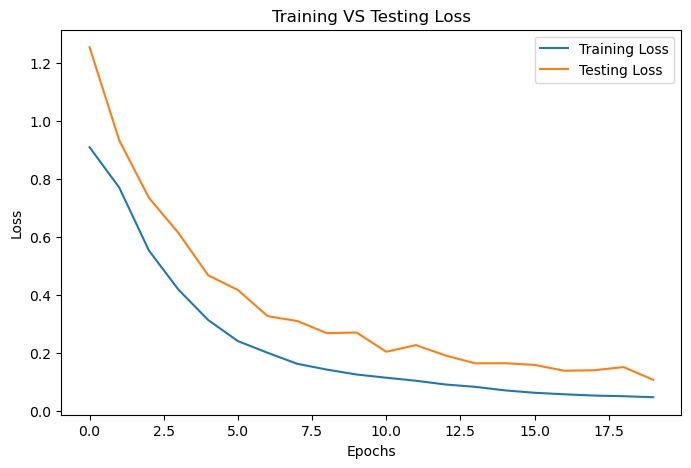

In [62]:
epochs = range(len(model_1_results['training_loss']))

plt.figure(figsize=(8, 5))
plt.plot(epochs, model_1_results['training_loss'], label='Training Loss')
plt.plot(epochs, model_1_results['testing_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training VS Testing Loss')
plt.legend()
plt.show()

# Recommeding Top 5 Candidates

In [64]:
X.columns

Index(['Age', 'Gender', 'Education', 'Marital status', 'Mode of Interview',
       'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Acquaintance and Referral', 'Candidate Status',
       'Last Fixed CTC (lakhs)', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'What was the type of Role?', 'Role acceptance',
       'Candidate is willing to relocate', 'Confidence Score',
       'Structured Thinking Score', 'Regional Fluency Score'],
      dtype='object')

In [65]:
employer_pref = {
    'Age': 21,
    'Gender': 'Male',
    'Education' : 'B.E / B-Tech',
    'Marital status' : 'Unmarried',
    'Mode of Interview' : 'Laptop',
    'Fluency in English based on introduction' : 'Able to speak sentences in a clear/coherent way. Smooth talker with one or two hiccups.',
    'Does the candidate has mother tongue influence while speaking english.' : 'No',
    'Acquaintance and Referral' : 'No',
    'Candidate Status' : 'Fresher(only 2022 grad)',
    'Last Fixed CTC (lakhs)' : 'Fresher',
    'Currently Employed' : 'Yes',
    'Experienced candidate - (Experience in months)' : 'Fresher(<6 months)',
    'What was the type of Role?' : 'Fresher',
    'Role acceptance' : 'Emphatic Yes',
    'Candidate is willing to relocate' : 'Yes',
    'Confidence Score' : 11,
    'Structured Thinking Score' : 7,
    'Regional Fluency Score' : 3, 
    'Total Score' : 48
}

In [66]:
employer_pref_df = pd.DataFrame([employer_pref])
type(employer_pref_df)

pandas.core.frame.DataFrame

In [67]:
employer_pref_transformed = preprocessing_pipeline.transform(employer_pref_df)
type(employer_pref_transformed)

numpy.ndarray

In [68]:
employer_pref_tensor = torch.tensor(employer_pref_transformed, dtype=torch.float32)
type(employer_pref_tensor)

torch.Tensor

In [69]:
employer_pref_tensor.shape, X_test_tensor.shape

(torch.Size([1, 28]), torch.Size([880, 28]))

In [70]:
with torch.no_grad():
    scores = F.cosine_similarity(employer_pref_tensor, X_test_tensor)

    ranking_df = pd.DataFrame({
        'id':X_test_index,
        'score':scores
    })

    ranked_candidates = ranking_df.sort_values(by='score', ascending=False)
    print(ranked_candidates[['id','score']].head())
    print(type(ranked_candidates))

        id     score
52   16632  0.881735
841  12243  0.855106
345    845  0.843251
209    184  0.834377
323   3797  0.810202
<class 'pandas.core.frame.DataFrame'>
